In [1]:
!pip install pandas
!pip install scikit-learn
!pip install torch
!pip install matplotlib
!pip install numpy

In [2]:
import pandas as pd
df = pd.read_csv("league_of_legends_data_large.csv")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
target_columns = ['Unnamed: 0','win']
X = df.drop(columns=target_columns,axis=1)
y = df['win']
# Convert the targets to binary labels
y = y.astype(int)

In [4]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# print the first few rows of the data
display(X.head())

# print the first few rows of the target
display(y.head())

,assists,GameID,GameMode,baronKills,bountyLevel,champExperience,champLevel,championName,damageDealtToObjectives,damageSelfMitigated,...,totalTimeCCDealt,totalTimeSpentDead,trueDamageDealtToChampions,trueDamageTaken,turretTakedowns,turretsLost,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced
0,14,NA1_4440772554,ARAM,0,0,19848,18,Yasuo,1978,36956,...,99,320,0,862,1,4,0,0,0,0
1,3,4035079604,CLASSIC,0,3,15453,16,Sett,18147,30659,...,131,156,2556,686,4,4,10,0,0,7
2,19,4035079604,CLASSIC,0,3,13168,15,Trundle,27626,28297,...,434,82,956,1571,6,4,21,3,0,11
3,6,4035079604,CLASSIC,0,1,13619,15,Sylas,10629,19937,...,323,127,600,935,6,4,8,0,0,5
4,7,4035079604,CLASSIC,1,1,10674,13,KogMaw,13624,6303,...,240,118,2202,521,3,4,3,1,1,2


,win
0,0
1,1
2,1
3,1
4,1


In [6]:
display(f'X shape: {X.shape}')
display(f'y shape: {y.shape}')

'X shape: (5001, 67)'

'y shape: (5001,)'

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

display(f'X_train shape: {X_train.shape}')
display(f'y_train shape: {y_train.shape}')
display(f'X_test shape: {X_test.shape}')
display(f'y_test shape: {y_test.shape}')

'X_train shape: (4000, 67)'

'y_train shape: (4000,)'

'X_test shape: (1001, 67)'

'y_test shape: (1001,)'

In [9]:
from torch.utils.data import DataLoader, TensorDataset

# Standardize the data
# Initialize the StandardScaler
scaler = StandardScaler()

# Select only numeric features for scaling
numeric_features = X_train.select_dtypes(include=['number']).columns

# Fit the scaler on the training data and transform it
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])

# Transform the test data using the same scaler
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Convert to PyTorch tensors
# Select only numeric features before converting to tensor
X_train_tensor = torch.tensor(X_train[numeric_features].values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test[numeric_features].values, dtype=torch.float32)

# Extract target values and convert to tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [10]:
print(X_train_tensor.shape[1])

57


In [11]:
# Create logistic_regression class

import torch.nn as nn

# Create logistic_regression class

import torch.nn as nn

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_units):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_units, 1)  # Linear layer

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Apply sigmoid activation

# Instantiate the model
model = LogisticRegressionModel(input_units=57)

In [12]:
print(X_train_tensor.shape[1])

57


In [13]:
print(model)

LogisticRegressionModel(
  (linear): Linear(in_features=57, out_features=1, bias=True)
)


In [14]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [15]:
epochs = 1000
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        # Convert y_batch to float before calculating loss
        # Reshape y_batch to have the same shape as outputs
        loss = criterion(outputs, y_batch.unsqueeze(1).float()) #  <- Change is here
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            # Convert y_batch to float before calculating loss
            # Reshape y_batch to have the same shape as test_outputs
            loss = criterion(test_outputs, y_batch.unsqueeze(1).float()) # <- Change is here
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch + 1}/100], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/100], Train Loss: 0.1764, Test Loss: 0.1178
Epoch [2/100], Train Loss: 0.1029, Test Loss: 0.1006
Epoch [3/100], Train Loss: 0.0891, Test Loss: 0.0876
Epoch [4/100], Train Loss: 0.0815, Test Loss: 0.0807
Epoch [5/100], Train Loss: 0.0774, Test Loss: 0.0755
Epoch [6/100], Train Loss: 0.0739, Test Loss: 0.0803
Epoch [7/100], Train Loss: 0.0716, Test Loss: 0.0713
Epoch [8/100], Train Loss: 0.0693, Test Loss: 0.0728
Epoch [9/100], Train Loss: 0.0679, Test Loss: 0.0703
Epoch [10/100], Train Loss: 0.0667, Test Loss: 0.0673
Epoch [11/100], Train Loss: 0.0652, Test Loss: 0.0659
Epoch [12/100], Train Loss: 0.0642, Test Loss: 0.0655
Epoch [13/100], Train Loss: 0.0632, Test Loss: 0.0681
Epoch [14/100], Train Loss: 0.0616, Test Loss: 0.0636
Epoch [15/100], Train Loss: 0.0608, Test Loss: 0.0637
Epoch [16/100], Train Loss: 0.0613, Test Loss: 0.0654
Epoch [17/100], Train Loss: 0.0605, Test Loss: 0.0662
Epoch [18/100], Train Loss: 0.0596, Test Loss: 0.0613
Epoch [19/100], Train Loss: 0.0592, T

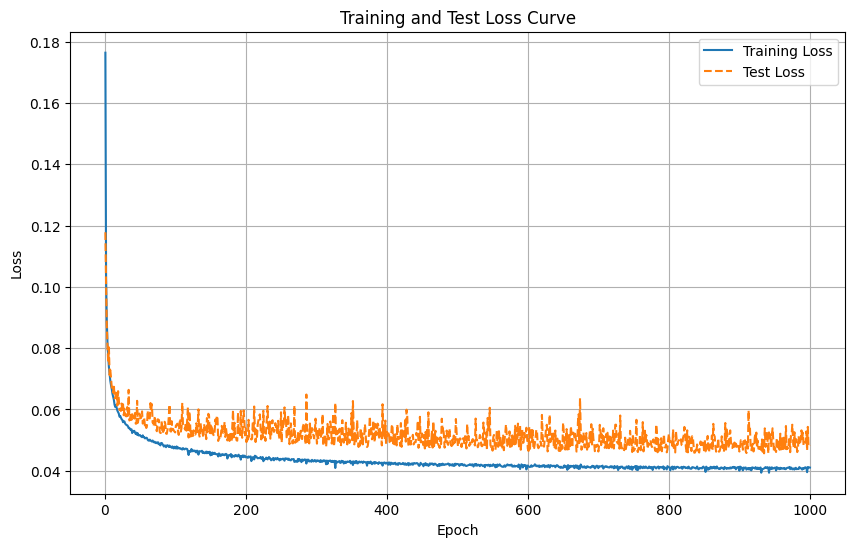

In [16]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
yhat_train = model(X_train_tensor)
label_train = (yhat_train > 0.5).float()
label_train = label_train.view(4000)
y_train_tensor = y_train_tensor.to(dtype=torch.float)
# print("yhat_train: ", yhat_train[0:10])
# print("label_train: ",label_train[0:10])
# print("y_train_tensor: ",y_train_tensor[0:10])
# print(label_train.size())
#print(y_train_tensor.size())
print("The training accuracy: ", torch.mean((label_train == y_train_tensor.type(torch.ByteTensor)).type(torch.float)))
yhat_test = model(X_test_tensor)
label_test = (yhat_test > 0.5).float()
label_test = label_test.view(1001)
y_train_tensor = y_train_tensor.to(dtype=torch.float)
print("The test accuracy: ", torch.mean((label_test == y_test_tensor.type(torch.ByteTensor)).type(torch.float)))


The training accuracy:  tensor(0.9808)
The test accuracy:  tensor(0.9820)


In [21]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

In [22]:
epochs = 1000
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        # Convert y_batch to float before calculating loss
        # Reshape y_batch to have the same shape as outputs
        loss = criterion(outputs, y_batch.unsqueeze(1).float()) #  <- Change is here
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            # Convert y_batch to float before calculating loss
            # Reshape y_batch to have the same shape as test_outputs
            loss = criterion(test_outputs, y_batch.unsqueeze(1).float()) # <- Change is here
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch + 1}/100], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/100], Train Loss: 0.0412, Test Loss: 0.0458
Epoch [2/100], Train Loss: 0.0436, Test Loss: 0.0523
Epoch [3/100], Train Loss: 0.0473, Test Loss: 0.0568
Epoch [4/100], Train Loss: 0.0520, Test Loss: 0.0657
Epoch [5/100], Train Loss: 0.0574, Test Loss: 0.0649
Epoch [6/100], Train Loss: 0.0636, Test Loss: 0.0722
Epoch [7/100], Train Loss: 0.0689, Test Loss: 0.0736
Epoch [8/100], Train Loss: 0.0737, Test Loss: 0.0861
Epoch [9/100], Train Loss: 0.0786, Test Loss: 0.0852
Epoch [10/100], Train Loss: 0.0818, Test Loss: 0.0861
Epoch [11/100], Train Loss: 0.0847, Test Loss: 0.0884
Epoch [12/100], Train Loss: 0.0877, Test Loss: 0.0911
Epoch [13/100], Train Loss: 0.0893, Test Loss: 0.0946
Epoch [14/100], Train Loss: 0.0909, Test Loss: 0.0964
Epoch [15/100], Train Loss: 0.0915, Test Loss: 0.0950
Epoch [16/100], Train Loss: 0.0931, Test Loss: 0.0969
Epoch [17/100], Train Loss: 0.0927, Test Loss: 0.0974
Epoch [18/100], Train Loss: 0.0939, Test Loss: 0.0953
Epoch [19/100], Train Loss: 0.0934, T

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 69 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      5001 non-null   int64 
 1   assists                         5001 non-null   int64 
 2   GameID                          5001 non-null   object
 3   GameMode                        5001 non-null   object
 4   baronKills                      5001 non-null   int64 
 5   bountyLevel                     5001 non-null   int64 
 6   champExperience                 5001 non-null   int64 
 7   champLevel                      5001 non-null   int64 
 8   championName                    5001 non-null   object
 9   damageDealtToObjectives         5001 non-null   int64 
 10  damageSelfMitigated             5001 non-null   int64 
 11  deaths                          5001 non-null   int64 
 12  dragonKills                     5001 non-null   

In [31]:
column_names_df = pd.DataFrame(df.columns, columns=['feature'])
print(column_names_df)

                    feature
0                Unnamed: 0
1                   assists
2                    GameID
3                  GameMode
4                baronKills
..                      ...
64              visionScore
65  visionWardsBoughtInGame
66              wardsKilled
67              wardsPlaced
68                      win

[69 rows x 1 columns]


In [41]:
feature_remove = ['Unnamed: 0','GameID','GameMode','championName','firstBloodAssist','firstBloodKill','gameEndedInSurrender']
feature_remove = feature_remove + ['individualPosition','lane','summonerId','teamEarlySurrendered','win']
# print(feature_remove)
indices_to_remove = column_names_df[column_names_df['feature'].isin(feature_remove)]
# print(indices_to_remove)
# column_names_df = column_names_df.drop(indices_to_remove)
filtered_df = column_names_df[~column_names_df['feature'].isin(feature_remove)]
print(filtered_df)
print(len(filtered_df))



                           feature
1                          assists
4                       baronKills
5                      bountyLevel
6                  champExperience
7                       champLevel
9          damageDealtToObjectives
10             damageSelfMitigated
11                          deaths
12                     dragonKills
16                      goldEarned
17                       goldSpent
19                  inhibitorKills
20                  inhibitorsLost
21                           item0
22                           item1
23                           item2
24                           item3
25                           item4
26                           item5
27                           item6
28                           kills
30           largestCriticalStrike
31             largestKillingSpree
32          longestTimeSpentLiving
33     magicDamageDealtToChampions
34                magicDamageTaken
35                       nexusLost
36                ob

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the weights of the linear layer
## Write your code here
# Access weights and bias
weights = model.linear.weight.data.numpy()  # Convert to NumPy array if needed
print("Weights (coefficients):", weights)
print("weights size: ",weights.size)
weights_1d = weights.reshape(-1)
weights_df = pd.DataFrame(weights_1d, columns=['weights'])
# print(weights_df)
# Add "ID" column with row numbers
weights_df['ID'] = range(1, len(weights_df) + 1)
print(weights_df)
# Create a DataFrame for feature importance
## Write your code here

Weights (coefficients): [[ 0.7610369   0.13278487  0.58040243  0.47330174  0.34484425  0.15807815
   0.0296006  -0.42034096  0.28299016  0.19700475 -0.09933444  0.14463925
  -0.49287975  0.03869692 -0.00440495 -0.03875153  0.02026686  0.10989393
   0.01559417  0.1046543   0.15502737 -0.05532611  0.07469834 -0.20814094
  -0.00722632 -0.03541136 -1.4634801  -0.01030351 -0.10074116 -0.04294581
  -0.04253527 -0.03431688 -0.01211668 -0.01350101 -0.05621319  0.00539574
  -0.07993118 -0.02173434 -0.11684683 -0.02495128  0.08280163 -0.0826785
  -0.03318084 -0.05620377 -0.01850177 -0.12467906 -0.03771313 -0.08740131
   0.09501255  0.05267742 -0.10731502  0.90910566 -1.6440213   0.06715468
   0.01371432 -0.00372192  0.14544691]]
weights size:  57
     weights  ID
0   0.761037   1
1   0.132785   2
2   0.580402   3
3   0.473302   4
4   0.344844   5
5   0.158078   6
6   0.029601   7
7  -0.420341   8
8   0.282990   9
9   0.197005  10
10 -0.099334  11
11  0.144639  12
12 -0.492880  13
13  0.038697  1

In [48]:
# Add "ID" column with row numbers
filtered_df['ID'] = range(1, len(filtered_df) + 1)

print(filtered_df)


                           feature  ID
1                          assists   1
4                       baronKills   2
5                      bountyLevel   3
6                  champExperience   4
7                       champLevel   5
9          damageDealtToObjectives   6
10             damageSelfMitigated   7
11                          deaths   8
12                     dragonKills   9
16                      goldEarned  10
17                       goldSpent  11
19                  inhibitorKills  12
20                  inhibitorsLost  13
21                           item0  14
22                           item1  15
23                           item2  16
24                           item3  17
25                           item4  18
26                           item5  19
27                           item6  20
28                           kills  21
30           largestCriticalStrike  22
31             largestKillingSpree  23
32          longestTimeSpentLiving  24
33     magicDamageDealtTo

<ipython-input-48-5fe1793cf86d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ID'] = range(1, len(filtered_df) + 1)


In [52]:
merged_df = pd.merge(filtered_df, weights_df, on='ID', how='left')
print(merged_df)

                           feature  ID   weights
0                          assists   1  0.761037
1                       baronKills   2  0.132785
2                      bountyLevel   3  0.580402
3                  champExperience   4  0.473302
4                       champLevel   5  0.344844
5          damageDealtToObjectives   6  0.158078
6              damageSelfMitigated   7  0.029601
7                           deaths   8 -0.420341
8                      dragonKills   9  0.282990
9                       goldEarned  10  0.197005
10                       goldSpent  11 -0.099334
11                  inhibitorKills  12  0.144639
12                  inhibitorsLost  13 -0.492880
13                           item0  14  0.038697
14                           item1  15 -0.004405
15                           item2  16 -0.038752
16                           item3  17  0.020267
17                           item4  18  0.109894
18                           item5  19  0.015594
19                  

In [53]:
merged_df_sorted = merged_df.sort_values(by='weights')
print(merged_df_sorted)

                           feature  ID   weights
52                     turretsLost  53 -1.644021
26                       nexusLost  27 -1.463480
12                  inhibitorsLost  13 -0.492880
7                           deaths   8 -0.420341
23          longestTimeSpentLiving  24 -0.208141
45           totalHealsOnTeammates  46 -0.124679
38                          teamId  39 -0.116847
50                 trueDamageTaken  51 -0.107315
28  physicalDamageDealtToChampions  29 -0.100741
10                       goldSpent  11 -0.099334
47                totalTimeCCDealt  48 -0.087401
41     totalDamageDealtToChampions  42 -0.082678
36                  summoner2Casts  37 -0.079931
34                  summoner1Casts  35 -0.056213
43                totalDamageTaken  44 -0.056204
21           largestCriticalStrike  22 -0.055326
29             physicalDamageTaken  30 -0.042946
30                     spell1Casts  31 -0.042535
15                           item2  16 -0.038752
46              tota

In [54]:
del merged_df_sorted['ID']
print(merged_df_sorted)

                           feature   weights
52                     turretsLost -1.644021
26                       nexusLost -1.463480
12                  inhibitorsLost -0.492880
7                           deaths -0.420341
23          longestTimeSpentLiving -0.208141
45           totalHealsOnTeammates -0.124679
38                          teamId -0.116847
50                 trueDamageTaken -0.107315
28  physicalDamageDealtToChampions -0.100741
10                       goldSpent -0.099334
47                totalTimeCCDealt -0.087401
41     totalDamageDealtToChampions -0.082678
36                  summoner2Casts -0.079931
34                  summoner1Casts -0.056213
43                totalDamageTaken -0.056204
21           largestCriticalStrike -0.055326
29             physicalDamageTaken -0.042946
30                     spell1Casts -0.042535
15                           item2 -0.038752
46              totalMinionsKilled -0.037713
25                magicDamageTaken -0.035411
31        

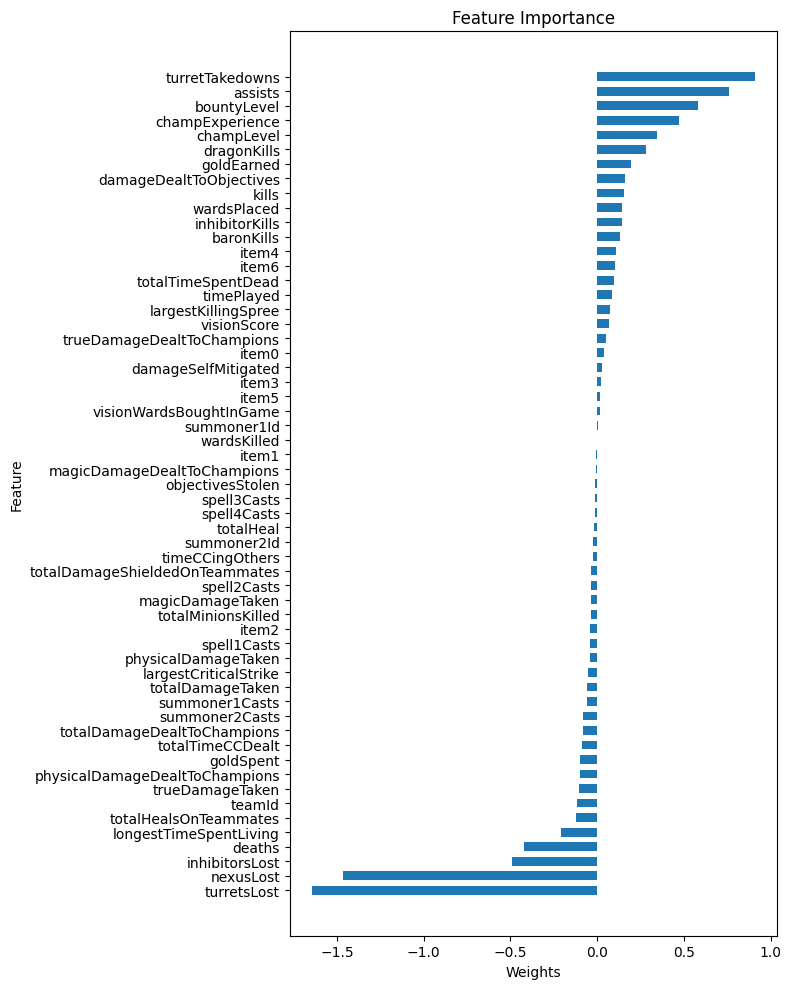

In [59]:
import pandas as pd
import matplotlib.pyplot as plt


# Plot
plt.figure(figsize=(8, 10))
plt.barh(merged_df_sorted['feature'], merged_df_sorted['weights'], height=0.6)
plt.xlabel('Weights')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()